In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from alphazero.coach import Coach
from alphazero.gomoku_game import GomokuGame as Game
from alphazero.interfaces import TrainParams
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.policies.softadvice import MaxInfluencePolicy, MaxInfluencePolicyParams, NeuralNetAdapter
from domoku.constants import *

In [3]:
def given_heuristic_brain():
    hard_policy = MaxCriticalityPolicy(board_size=BOARD_SIZE, overconfidence=5.0)
    params = MaxInfluencePolicyParams(
        board_size=BOARD_SIZE,
        sigma=.6,
        iota=6,
        radial_constr=[.0625, .125, .25, .5],
        radial_obstr=[-.0625, -.125, -.25, -.5]
    )
    policy = MaxInfluencePolicy(params, criticality_model=hard_policy, pov=BLACK)
    return NeuralNetAdapter(policy)

In [4]:
BOARD_SIZE = 15

params = TrainParams(
    update_threshold=0.6,
    max_queue_length=200000,    # Number of game examples to train the neural networks.
    num_simulations=25,
    arena_compare=40,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=20,
    num_iterations=1000,
    num_episodes=100,
    temperature_threshold=15
)

brain = given_heuristic_brain()

detector = MaxCriticalityPolicy(BOARD_SIZE)

game = Game(15, detector=detector, initial='H8', model=brain)

game.get_initial_board()

coach = Coach(game, brain, params)

2022-06-11 23:01:13.288291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [5]:
train_examples = coach.execute_episode()

In [6]:
len(train_examples)

280

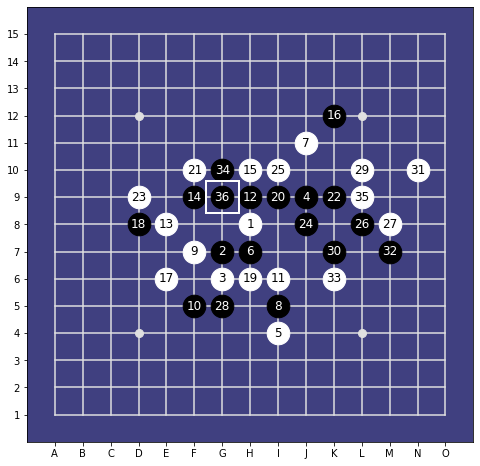

In [7]:
stones = coach.recover_moves(train_examples)
from domoku.board import GomokuBoard as LegacyBoard
board = LegacyBoard(n=15, disp_width=8, stones=[stone.xy() for stone in stones])
board.display()

In [8]:
train_examples[0][0].shape

(17, 17, 3)

In [9]:
np.shape(train_examples[0][1])

(225,)

In [10]:
from alphazero.gomoku_model import GomokuModel

In [11]:
model = GomokuModel(input_size=17, kernel_size=11)

In [12]:
subset = train_examples  # [:10]
x_train = np.asarray([t[0] for t in subset], dtype=float)
pi_train = np.asarray([t[1] for t in subset])
v_train = np.asarray([t[2] for t in subset])

In [13]:
x_train.shape, pi_train.shape, v_train.shape

((280, 17, 17, 3), (280, 225), (280,))

In [14]:
x_train_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(1024)
pi_train_ds = tf.data.Dataset.from_tensor_slices(pi_train).batch(1024)
v_train_ds = tf.data.Dataset.from_tensor_slices(v_train).batch(1024)
all_train_ds = tf.data.Dataset.zip((x_train_ds, pi_train_ds, v_train_ds))

In [15]:
x, _, _ = iter(all_train_ds).next()
model(x);

In [16]:
model.summary()

Model: "gomoku_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           multiple                  11648     
                                                                 
 Potential_0 (Conv2D)        multiple                  123936    
                                                                 
 Potential_1 (Conv2D)        multiple                  123936    
                                                                 
 Potential_2 (Conv2D)        multiple                  123936    
                                                                 
 Potential_3 (Conv2D)        multiple                  123936    
                                                                 
 Potential_4 (Conv2D)        multiple                  123936    
                                                                 
 conv2d_10 (Conv2D)          multiple                 

In [17]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
value_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

# model.compile(loss=[policy_loss, value_loss], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [18]:
@tf.function
def train_step(model, optimizer, x, pi_y, v_y):
    with tf.GradientTape() as tape:
        p, v = model(x, training=True)
        loss1 = policy_loss(pi_y, p)
        loss2 = value_loss(v_y, v)
        total_loss = loss1 + loss2
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(total_loss)

def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = policy_loss(y_test, predictions)

    # test_loss(loss)
    # test_accuracy(y_test, predictions)

In [19]:
import datetime as dt
current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [21]:
EPOCHS = 40

for epoch in range(EPOCHS):
    for x_train, pi_train, v_train in all_train_ds:
        train_step(model, optimizer, x_train, pi_train, v_train)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # for x_test, y_test in test_dataset:
    #     test_step(model, x_test, y_test)
    # with train_summary_writer.as_default():
    #     tf.summary.scalar('loss', test_loss.result(), step=epoch)
    #     tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)


    template = 'Epoch {}, Loss: {}'
    print (template.format(epoch+1, train_loss.result()*100))

    train_loss.reset_states()


Epoch 1, Loss: 690.7377319335938
Epoch 2, Loss: 690.4693603515625
Epoch 3, Loss: 690.0469970703125
Epoch 4, Loss: 689.593994140625
Epoch 5, Loss: 689.2725830078125
Epoch 6, Loss: 688.87158203125
Epoch 7, Loss: 689.0869140625
Epoch 8, Loss: 690.2841796875
Epoch 9, Loss: 688.6613159179688
Epoch 10, Loss: 695.4260864257812
Epoch 11, Loss: 697.8526000976562
Epoch 12, Loss: 701.767333984375
Epoch 13, Loss: 705.4214477539062
Epoch 14, Loss: 704.8487548828125
Epoch 15, Loss: 701.4706420898438
Epoch 16, Loss: 699.0485229492188
Epoch 17, Loss: 697.503173828125
Epoch 18, Loss: 698.8695068359375
Epoch 19, Loss: 697.356689453125
Epoch 20, Loss: 696.7491455078125
Epoch 21, Loss: 702.9454345703125
Epoch 22, Loss: 696.344482421875
Epoch 23, Loss: 696.8875732421875
Epoch 24, Loss: 696.3131103515625
Epoch 25, Loss: 696.4027099609375
Epoch 26, Loss: 695.7987670898438
Epoch 27, Loss: 695.0916137695312
Epoch 28, Loss: 694.202392578125
Epoch 29, Loss: 694.1707763671875
Epoch 30, Loss: 692.9716796875
Epoch 